In [75]:
import tweepy
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\naik\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
# Add your Bearer token here.
client = tweepy.Client(bearer_token='')

# Create Pandas dataframe with three columns
tweet_df = pd.DataFrame(columns=['text', 'language'])

# Query tweets with #news. Show only 100 tweets
query = '#news'
tweets = client.search_recent_tweets(query=query, tweet_fields=['lang'], max_results=10)

for tweet in tweets.data:
    text = tweet.text
    language = tweet.lang

    # Focus only to tweets in english
    if language == 'en':
        tmp = [text, language]
        tweet_df.loc[len(tweet_df)] = tmp

# Total amount of tweets in dataframe
print('Amount: ', len(tweet_df))

# Show first 5 lines of dataframe
tweet_df.head()

Amount:  9


,text,language
0,"If Jake Muzzin is back for playoffs, which def...",en
1,IDeaS and RMS Cloud Enhance Technology Partner...,en
2,Kharkov night sky illuminated by Russian Force...,en
3,InterContinental Paris Le Grand Enters the Ren...,en
4,RT @dispatchdcu: Out now! Wolverine #20 Review...,en


In [6]:
truenews = pd.read_csv("../files/True.csv")
fakenews = pd.read_csv("../files/Fake.csv")

truenews['label'] = 1
fakenews['label'] = 0

news_df = pd.concat([truenews, fakenews])
news_df = news_df.sample(frac = 1).reset_index(drop=True)
news_df.head()

,title,text,subject,date,label
0,Factbox: Passport to Catalonia - how to achiev...,GENEVA (Reuters) - Leaders of Spain s industri...,worldnews,"October 5, 2017",1
1,Kenya opposition leader: supporters should boy...,NAIROBI (Reuters) - Kenya opposition leader Ra...,worldnews,"October 25, 2017",1
2,Czech president plans to appoint Babis's cabin...,PRAGUE (Reuters) - Czech President Milos Zeman...,worldnews,"November 23, 2017",1
3,LIVE FEED AT 1:00 P.M. EST: 100% FED Up! AMERI...,This HUGE rally to protest against the Iran de...,Government News,"Sep 9, 2015",0
4,Amnesty International urges halt to Afghan ref...,KABUL (Reuters) - The human rights group Amnes...,worldnews,"October 5, 2017",1


In [7]:
print("Does Twitter Dataframe contain null values: ", tweet_df.isnull().values.any())
print("Does News Dataframe contain null values: ", news_df.isnull().values.any(), "\n")

print("Twitter dataframe datatypes: \n", tweet_df.dtypes, "\n")
print("News dataframe datatypes: \n", news_df.dtypes)

Does Twitter Dataframe contain null values:  False
Does News Dataframe contain null values:  False 

Twitter dataframe datatypes: 
 text        object
language    object
dtype: object 

News dataframe datatypes: 
 title      object
text       object
subject    object
date       object
label       int64
dtype: object


In [8]:
def deEmojify(text):
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regex_pattern.sub(r'', text)

def clean_text(tweet):
    # Lower case text
    tweet = tweet.lower()

    # Remove mentions
    tweet = re.sub("@[A-Za-z0-9]+","", tweet)

    # Remove links
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)

    # Remove hastags
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)

    # Remove punctuations
    tweet = re.sub('[()!?]', ' ', tweet)
    tweet = re.sub('\[.*?\]',' ', tweet)

    # Remove emoticons
    tweet = deEmojify(tweet)

    # Filter non-alphanumeric characters (double check...)
    tweet = re.sub("[^a-z0-9]"," ", tweet)

    # Tokenize tweet (split...)
    tokens = word_tokenize(tweet)

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    cleaned_tweet = ' '.join(tokens)

    return cleaned_tweet

test_text = "The @SpaceX Dragon Endeavour with four @Axiom_Space astronauts is holding 20 meters away from the station as the station crew works a video routing issue. https://nasa.gov/live"
print("Before: ", test_text)
print("After: ", clean_text(test_text))


Before:  The @SpaceX Dragon Endeavour with four @Axiom_Space astronauts is holding 20 meters away from the station as the station crew works a video routing issue. https://nasa.gov/live
After:  dragon endeavour four space astronauts hold 20 meter away station station crew work video rout issue


In [9]:
news_df['clean_text'] = np.nan

news_df['clean_text'] = [clean_text(x) for x in news_df['title']]

news_df.dropna(subset=['clean_text'], inplace=True)
news_df.drop_duplicates(subset=['text', 'clean_text'], keep=False, inplace=True)

news_df.head()

,title,text,subject,date,label,clean_text
0,Factbox: Passport to Catalonia - how to achiev...,GENEVA (Reuters) - Leaders of Spain s industri...,worldnews,"October 5, 2017",1,factbox passport catalonia achieve independence
1,Kenya opposition leader: supporters should boy...,NAIROBI (Reuters) - Kenya opposition leader Ra...,worldnews,"October 25, 2017",1,kenya opposition leader supporters boycott pol...
2,Czech president plans to appoint Babis's cabin...,PRAGUE (Reuters) - Czech President Milos Zeman...,worldnews,"November 23, 2017",1,czech president plan appoint babis cabinet mid...
3,LIVE FEED AT 1:00 P.M. EST: 100% FED Up! AMERI...,This HUGE rally to protest against the Iran de...,Government News,"Sep 9, 2015",0,live fee 1 00 p est 100 feed americans rally c...
4,Amnesty International urges halt to Afghan ref...,KABUL (Reuters) - The human rights group Amnes...,worldnews,"October 5, 2017",1,amnesty international urge halt afghan refugee...


In [10]:
tweet_df['clean_text'] = np.nan

tweet_df['clean_text'] = [clean_text(x) for x in tweet_df['text']]

tweet_df.dropna(subset=['clean_text'], inplace=True)
tweet_df.drop_duplicates(subset=['text', 'clean_text'], keep=False, inplace=True)

tweet_df.head()

,text,language,clean_text
0,"If Jake Muzzin is back for playoffs, which def...",en,jake muzzin back playoffs defenceman stay come...
1,IDeaS and RMS Cloud Enhance Technology Partner...,en,ideas rms cloud enhance technology partnership...
2,Kharkov night sky illuminated by Russian Force...,en,kharkov night sky illuminate russian force
3,InterContinental Paris Le Grand Enters the Ren...,en,intercontinental paris le grand enter rendezverse
4,RT @dispatchdcu: Out now! Wolverine #20 Review...,en,rt wolverine review


In [11]:
clean_text_combined = pd.concat([news_df['clean_text'], tweet_df['clean_text']])
clean_text_combined.head()
print("All clean texts combined size: ", clean_text_combined.size)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_text_combined)

def tokenize(text):
    tmp_text = tokenizer.texts_to_sequences(text)
    tmp_text = pad_sequences(tmp_text, padding='post', maxlen=232)
    return tmp_text

All clean texts combined size:  33804


In [12]:
tweet_df['sequence'] = np.nan
tweet_df['sequence'] = list(tokenize(tweet_df['clean_text']))

tweet_df.head()

,text,language,clean_text,sequence
0,"If Jake Muzzin is back for playoffs, which def...",en,jake muzzin back playoffs defenceman stay come...,"[1713, 14726, 40, 9276, 14727, 564, 239, 14728..."
1,IDeaS and RMS Cloud Enhance Technology Partner...,en,ideas rms cloud enhance technology partnership...,"[2348, 14729, 3209, 5546, 3572, 4009, 14730, 7..."
2,Kharkov night sky illuminated by Russian Force...,en,kharkov night sky illuminate russian force,"[14731, 738, 2809, 14732, 56, 90, 0, 0, 0, 0, ..."
3,InterContinental Paris Le Grand Enters the Ren...,en,intercontinental paris le grand enter rendezverse,"[14733, 566, 2902, 1918, 1407, 14734, 0, 0, 0,..."
4,RT @dispatchdcu: Out now! Wolverine #20 Review...,en,rt wolverine review,"[6224, 14735, 385, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
news_df['sequence'] = np.nan
news_df['sequence'] = list(tokenize(news_df['clean_text']))

news_df.head()

,title,text,subject,date,label,clean_text,sequence
0,Factbox: Passport to Catalonia - how to achiev...,GENEVA (Reuters) - Leaders of Spain s industri...,worldnews,"October 5, 2017",1,factbox passport catalonia achieve independence,"[82, 3473, 439, 4602, 330, 0, 0, 0, 0, 0, 0, 0..."
1,Kenya opposition leader: supporters should boy...,NAIROBI (Reuters) - Kenya opposition leader Ra...,worldnews,"October 25, 2017",1,kenya opposition leader supporters boycott pol...,"[712, 171, 62, 233, 1025, 97, 178, 4234, 0, 0,..."
2,Czech president plans to appoint Babis's cabin...,PRAGUE (Reuters) - Czech President Milos Zeman...,worldnews,"November 23, 2017",1,czech president plan appoint babis cabinet mid...,"[1474, 16, 30, 1041, 2349, 558, 2136, 1184, 0,..."
3,LIVE FEED AT 1:00 P.M. EST: 100% FED Up! AMERI...,This HUGE rally to protest against the Iran de...,Government News,"Sep 9, 2015",0,live fee 1 00 p est 100 feed americans rally c...,"[224, 1272, 360, 7446, 780, 1673, 839, 613, 24..."
4,Amnesty International urges halt to Afghan ref...,KABUL (Reuters) - The human rights group Amnes...,worldnews,"October 5, 2017",1,amnesty international urge halt afghan refugee...,"[2137, 1068, 91, 840, 713, 512, 265, 0, 0, 0, ..."


In [81]:
train_df, test_df = train_test_split(news_df, test_size=0.2)
train_df.head()

,title,text,subject,date,label,clean_text,sequence
35810,"Factbox: Five facts about Mike Pompeo, expecte...",(Reuters) - The following are five facts about...,politicsNews,"November 30, 2017",1,factbox five facts mike pompeo expect replace ...,"[82, 506, 1185, 806, 4466, 334, 816, 186, 0, 0..."
38344,"EU pushes to curb Africa migration more, still...",BRUSSELS (Reuters) - European Union leaders wi...,worldnews,"December 12, 2017",1,eu push curb africa migration still split host...,"[48, 196, 939, 575, 1659, 286, 1339, 190, 277,..."
3507,Catalan uncertainty paralyzing regional invest...,MADRID (Reuters) - Investment projects in the ...,worldnews,"October 5, 2017",1,catalan uncertainty paralyze regional investme...,"[273, 2803, 5773, 1265, 1696, 407, 623, 55, 3,..."
9661,Trump's trust in Flynn had been eroding: White...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"February 14, 2017",1,trump trust flynn erode white house spokesman,"[1, 1599, 420, 6924, 8, 5, 475, 0, 0, 0, 0, 0,..."
10335,Factbox: Women who have alleged inappropriate ...,(Reuters) - Several women have accused U.S. Re...,politicsNews,"October 13, 2016",1,factbox women allege inappropriate conduct trump,"[82, 144, 1084, 2180, 1601, 1, 0, 0, 0, 0, 0, ..."


In [78]:
tokenized_counts = Counter(tokenizer.word_counts)
tokenized_df = pd.DataFrame([tokenized_counts.keys(), tokenized_counts.values()]).T
tokenized_df.columns=['word', 'quantity']
tokenized_df = tokenized_df.sort_values(by='quantity', ascending=False)

tokenized_df.head(10)

,word,quantity
49,trump,11761
62,u,4791
98,say,3810
185,video,2882
110,house,1785
259,obama,1690
61,new,1304
109,white,1292
368,watch,1262
67,clinton,1193


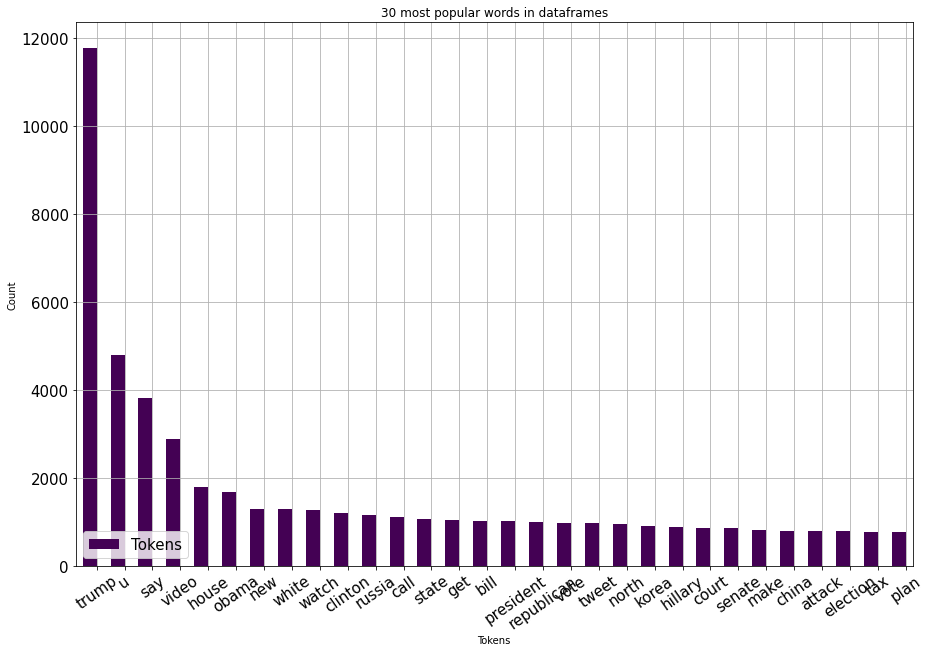

In [87]:
tokenized_df[:30].plot(kind="bar",x="word", orientation="vertical", figsize=(15,10), xlabel="Tokens", ylabel="Count", colormap="viridis", table=False, grid=True, fontsize=15, rot=35, position=1, title="30 most popular words in dataframes", legend=True).legend(["Tokens"], loc="lower left", prop={"size":15})

<AxesSubplot:>

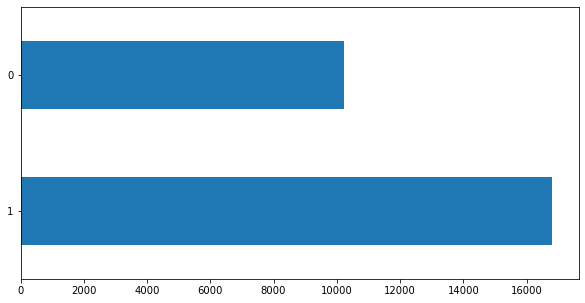

In [85]:
train_df['label'].value_counts().plot(kind='barh', figsize=(10,5))

<AxesSubplot:>

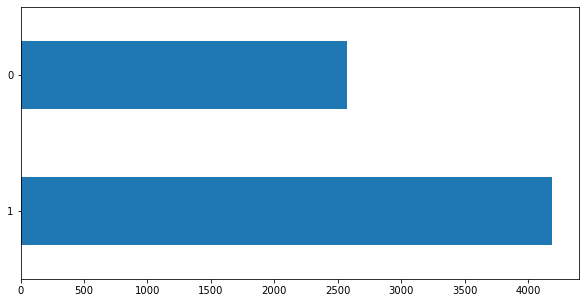

In [86]:
test_df['label'].value_counts().plot(kind='barh', figsize=(10,5))